In [276]:
import pyworld as pw
import yaml
from acoustics import CheapTrick
from loss import SSIMLossLayer, SpectralFlatnessLoss
from util import *
import torchaudio
from main import get_envelope
import torch
import numpy as np
import IPython.display as ipd
import parselmouth

In [308]:
with open('audios/en_sample/config.yaml') as file:
    config = yaml.load(file, Loader=yaml.FullLoader)

adv_path = config['prompt']['adv_path']
sr = config['prompt']['sample_rate']
audio_prompt = load_wav(config['prompt']['audio_path'], sr)
reference = load_wav(config['prompt']['reference_path'], sr)



In [127]:
ipd.Audio(audio_prompt, rate=sr)

In [190]:
ipd.Audio(reference, rate=sr)

In [218]:
downsample_rate = 1

In [217]:
target_sr = sr // downsample_rate

In [263]:
L2Loss = torch.nn.MSELoss()

In [265]:

def optimize_input(ssim_layer, audio, strength_weight=0.01, num_steps=10000, lr=0.001, device='cuda',
        output=True, sr=22050, downsample_rate=20):

    f0, time_stamp = pw.dio(audio.flatten().numpy().astype(np.float64), sr, frame_period=5.0)
    f0 = torch.tensor(f0).to(device)
    time_stamp = torch.tensor(time_stamp).to(device)

    envelope_layer = CheapTrick(fs=sr).to(device)
    
    ssim_layer = ssim_layer.to(device)

    x = audio.clone().detach().flatten()
    x = x.to(device)
    x.requires_grad_(True)

    optimizer = torch.optim.Adam([x], lr=lr)

    loss_history = []
    patience = 5
    no_progress_counter = 0
    no_progress_threshold = 1e-3
    
    
   # resampler = torchaudio.transforms.Resample(sr, sr // downsample_rate).to(device)
    


    for step in range(num_steps):
        optimizer.zero_grad()
        
        envelop = envelope_layer(x, f0, time_stamp)
        envelop = tensor_normalize(envelop)
        #print(envelop.device, ssim_layer.reference.device, ssim_layer.device)
        ssim_loss = ssim_layer(envelop)

        l2_loss = L2Loss(envelop, ssim_layer.reference.squeeze(0))
        print(l2_loss)
        loss = l2_loss

        if not torch.isfinite(loss):
            print(f"Optimization stopped at step {step} due to invalid loss (NaN or Inf).")
            break

        if len(loss_history) > 0 and loss_history[-1] - loss.item() < no_progress_threshold:
            no_progress_counter += 1
        else:
            no_progress_counter = 0

        if no_progress_counter > patience:
            print(f"Optimization stopped at step {step}, loss: {loss.item()}")
            break

        loss_history.append(loss.item())

        loss.backward()
        optimizer.step()

        if step % 5 == 0 and output:
            print(f"Step {step}, Loss: {loss.item()}")



    return x, loss_history

In [332]:
def optimize_input_2(ssim_layer, audio, strength_weight=0.01, num_steps=200, lr=0.001, device='cuda',
        output=True, sr=22050):

    f0, time_stamp = pw.dio(audio.flatten().numpy().astype(np.float64), sr, frame_period=5.0)
    f0 = torch.tensor(f0).double().to(device)
    time_stamp = torch.tensor(time_stamp).double().to(device)

    envelope_layer = CheapTrick(fs=sr).double().to(device)
    ssim_layer = ssim_layer.double().to(device)

    x = audio.clone().detach().flatten().double()
    x = x.to(device)
    x.requires_grad_(True)

    optimizer = torch.optim.Adam([x], lr=lr)

    loss_history = []
    patience = 5
    no_progress_counter = 0
    no_progress_threshold = 1e-3

    for step in range(num_steps):
        optimizer.zero_grad()

        envelop = envelope_layer(x, f0, time_stamp)
        envelop = tensor_normalize(envelop)
        ssim_loss = ssim_layer(envelop)


        loss = ssim_loss

        if not torch.isfinite(loss):
            print(f"Optimization stopped at step {step} due to invalid loss (NaN or Inf).")
            break

        if len(loss_history) > 0 and loss_history[-1] - loss.item() < no_progress_threshold:
            no_progress_counter += 1
        else:
            no_progress_counter = 0

        if no_progress_counter > patience:
            print(f"Optimization stopped at step {step}, loss: {loss.item()}")
            break

        loss_history.append(loss.item())

        loss.backward()
        optimizer.step()

        if step % 5 == 0 and output:
            print(f"Step {step}, Loss: {loss.item()}")



    return x, loss_history

In [330]:
sr = config['prompt']['sample_rate']
audio_prompt = load_wav(config['prompt']['audio_path'], sr)
reference = load_wav(config['prompt']['reference_path'], sr)
promp_envelope = get_envelope(audio_prompt, sr)
ref_envelope = get_envelope(reference, sr)
print(promp_envelope.shape, ref_envelope.shape)

assert ref_envelope.shape[1] >= promp_envelope.shape[1], "Reference audio should be equal or longer than prompt audio"

ref_envelope = ref_envelope[:, :promp_envelope.shape[1]]
normalized_ref = tensor_normalize(ref_envelope)
normalized_prompt = tensor_normalize(promp_envelope)
ssim_layer = SSIMLossLayer(normalized_ref.double().to('cuda'), device='cuda')
x_adv, loss_history = optimize_input_2(ssim_layer, audio_prompt, device='cuda', sr=sr)
torchaudio.save(adv_path, x_adv.cpu().float().detach().unsqueeze(0), sr)

torch.Size([513, 1567]) torch.Size([513, 1617])
Step 0, Loss: 0.3155853427621014


KeyboardInterrupt: 

In [320]:
def to_sine(path):
    audio = parselmouth.Sound(path)
    pitch = audio.to_pitch()
    pitch_syn = pitch.to_sound_sine()
    return pitch_syn
    

In [321]:
audio_prompt_sine = to_sine(config['prompt']['audio_path'])
ssr = audio_prompt_sine.sampling_frequency
audio_prompt_sine_torch = torchaudio.transforms.Resample(ssr, sr)(torch.tensor(audio_prompt_sine.values).float())
audio_prompt_sine_torch.shape

torch.Size([1, 172652])

In [334]:
ipd.Audio(audio_prompt_sine_torch, rate=sr)

In [338]:
sr = config['prompt']['sample_rate']
audio_prompt = load_wav(config['prompt']['audio_path'], sr)
reference = load_wav(config['prompt']['reference_path'], sr)
promp_envelope = get_envelope(audio_prompt, sr)
ref_envelope = get_envelope(audio_prompt_sine_torch, sr)
print(promp_envelope.shape, ref_envelope.shape)

assert ref_envelope.shape[1] >= promp_envelope.shape[1], "Reference audio should be equal or longer than prompt audio"

ref_envelope = ref_envelope[:, :promp_envelope.shape[1]]
normalized_ref = tensor_normalize(ref_envelope)
normalized_prompt = tensor_normalize(promp_envelope)
ssim_layer = SSIMLossLayer(normalized_ref.double().to('cuda'), device='cuda')
x_adv, loss_history = optimize_input_2(ssim_layer, audio_prompt, device='cuda', sr=sr,lr=0.0001)
torchaudio.save(adv_path, x_adv.cpu().float().detach().unsqueeze(0), sr)

torch.Size([513, 1567]) torch.Size([513, 1567])
Step 0, Loss: 0.4135367293747065
Step 5, Loss: 0.3943662112925973
Step 10, Loss: 0.37744933292036964
Step 15, Loss: 0.36460789897524926
Step 20, Loss: 0.354263105178926
Step 25, Loss: 0.34545419368426133
Step 30, Loss: 0.3378531062122392
Step 35, Loss: 0.33122217057479875
Step 40, Loss: 0.32503930181300256
Step 45, Loss: 0.31965788607918366
Step 50, Loss: 0.31463997712538205
Step 55, Loss: 0.30982551922518536
Optimization stopped at step 57, loss: 0.3081396924588037


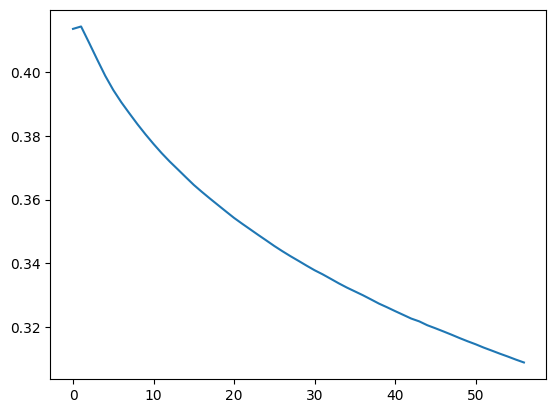

In [339]:
# plot loss history
import matplotlib.pyplot as plt
plt.plot(loss_history)
plt.show()

In [337]:
print(audio_prompt.shape, reference.shape)

promp_envelope = get_envelope(audio_prompt, sr)
ref_envelope = get_envelope(audio_prompt_sine_torch, sr)
print(promp_envelope.shape, ref_envelope.shape)

assert ref_envelope.shape[1] >= promp_envelope.shape[1], "Reference audio should be equal or longer than prompt audio"

ref_envelope = ref_envelope[:, :promp_envelope.shape[1]]
normalized_ref = tensor_normalize(ref_envelope)
ssim_layer = SSIMLossLayer(normalized_ref.to('cpu'), device='cpu')
x_adv, loss_history = optimize_input(ssim_layer, audio_prompt, device='cpu', sr=sr, lr=0.0001)
torchaudio.save(adv_path, x_adv.cpu().float().detach().unsqueeze(0), sr)

torch.Size([1, 172652]) torch.Size([1, 178176])
torch.Size([513, 1567]) torch.Size([513, 1567])
tensor(0.0732, grad_fn=<MseLossBackward0>)
Step 0, Loss: 0.07319451123476028
tensor(0.0703, grad_fn=<MseLossBackward0>)
tensor(0.0683, grad_fn=<MseLossBackward0>)
tensor(0.0664, grad_fn=<MseLossBackward0>)
tensor(0.0653, grad_fn=<MseLossBackward0>)


KeyboardInterrupt: 

In [271]:
ipd.Audio(adv_path, rate=sr)
